## Предсказание стоимости автомобиля марки Ford по VIN коду
Необходимо построить модель, предсказывающую стоимость автомобидей марки Ford на основании VIN-кода. В нашем распоряжении имеется файл vin_ford_train.txt 

Примечание:
- метрику для оценки качества предсказания модели выбрать самостоятельно;
- написать функцию или класс, которая на вход принимает  VIN-код (список кодов или строку), выдает информаци. об автомобиле и предсказанную стоимость.

Импорт необходимых библиотек:

In [263]:
import matplotlib.pyplot as plt
import numpy as np
import optuna
import os
import pandas as pd
import phik
import re
import seaborn as sns
import shap
import warnings

from catboost import CatBoostRegressor, Pool
from lightgbm import LGBMRegressor
from sklearn.compose import make_column_transformer
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder

### `Константы`

In [264]:
RANDOM_STATE = 61123
# выделение в тексте
BOLD = '\033[1m'
END = '\033[0m'

# Разрешенные символы
ALLOWED_CHARS = [chr(x) for x in range(ord('A'), ord('Z')+1) if chr(x) not in ('I', 'O', 'Q')]
ALLOWED_NUMS = [str(x) for x in range(1,10)] + ['0']
ALLOWED = ''.join(ALLOWED_CHARS+ALLOWED_NUMS)

In [265]:
# словарь, содержащий мировые индексы производителей (wmi), выпускающих автомобили марки Ford
FORD_WMI = {
    'AFA': 'Ford Motor Company of Southern Africa & Samcor',
    'AFB': 'Mazda BT-50 made by Ford Motor Company of Southern Africa',
    'JC0': 'Ford brand cars made by Mazda',
    'JC2': 'Ford Courier made by Mazda',
    'KNJ': 'Ford Festiva & Aspire made by Kia',
    'LJX': 'JMC Ford',
    'LVS': 'Changan Ford & Changan Ford Mazda',
    'MAJ': 'Ford India',
    'MNB': 'Ford Thailand',
    'NM0': 'Ford Otosan',
    'PE1': 'Ford Motor Company Philippines',
    'PE3': 'Mazda Philippines made by Ford Motor Company Philippines',
    'PR8': 'Ford',
    'LFA': 'Ford Lio Ho Motor Co Ltd. old designation',
    'RHA': 'Ford Lio Ho Motor Co Ltd. new designation',
    'RL0': 'Ford Vietnam',
    'SBC': 'Iveco Ford Truck',
    'SFA': 'Ford UK',
    'VSK': 'Nissan Motor Iberica SA, Nissan passenger car/MPV/van/SUV/pickup & Ford Maverick 1993–1999',
    'VS6': 'Ford Spain',
    'WF0': 'Ford Germany',
    'X9F': 'Ford Motor Company ZAO',
    'Z6F': 'Ford Sollers (Russia)',
    '1FA': 'Ford car',
    '1FB': 'Ford "bus" (van with more than 3 rows of seats)',
    '1FC': 'Ford stripped chassis made by Ford',
    '1FD': 'Ford incomplete vehicle',
    '1FM': 'Ford MPV/SUV',
    '1FT': 'Ford truck',
    '1F1': 'Ford SUV - Limousine (through 2009)',
    '1F6': 'Ford stripped chassis made by Detroit Chassis LLC',
    '1ZV': 'Ford made by AutoAlliance International',
    '2FA': 'Ford car',
    '2FM': 'Ford MPV/SUV',
    '2FT': 'Ford truck',
    '3FA': 'Ford car',
    '3FC': 'Ford stripped chassis made by Ford & IMMSA',
    '3FE': 'Ford Mexico',
    '3FM': 'Ford MPV/SUV',
    '3FN': 'Ford F-650/F-750 made by Blue Diamond Truck Co. (truck)',
    '3FR': 'Ford F-650/F-750 made by Blue Diamond Truck Co. (incomplete vehicle)',
    '3FT': 'Ford truck',
    '4F2': 'Mazda SUV made by Ford',
    '4F4': 'Mazda truck made by Ford',
    '4N2': 'Nissan Quest made by Ford',
    '5LD': 'Ford & Lincoln incomplete vehicle – limousine (2010–2014)',
    '6F1': 'Ford',
    '6FP': 'Ford Australia',
    '7A5': 'Ford New Zealand',
    '8AF': 'Ford Argentina',
    '9BF': 'Ford Brazil',
}

### `Настройки оформления`

In [266]:
pd.set_option('display.max_columns', None)
warnings.simplefilter("ignore", category=FutureWarning)

# matplotlib, seaborn
sns.set_style('whitegrid', {'axes.facecolor': '0.98', 'grid.color': '0.9', 'axes.edgecolor': '1.0'})

### `Вспомогательные функции`

In [280]:
# Функция, проверяющая валидность номера
def check_valid(s: str, flag_train: bool) -> list:
    valid_vin = r'(\w{14}\d{3})'
    valid_price = r'(\d+)'

    invalid_vin = r'(?!\w{14}\d{3})(\w+)'
    invalid_price = r'(?!\d+)(\w+)'

    if flag_train:
        invalid_var = [
            f'\\[{invalid_vin}:{valid_price}\\]',
            f'\\[{valid_vin}:{invalid_price}\\]',
            f'\\[{invalid_vin}:{invalid_price}\\]',
        ]

        invalid_pattern = re.compile('(?P<invalid_data>' + '|'.join(invalid_var) + ')')
    
    else:
        invalid_pattern = re.compile('(?P<invalid_vin>' + f'\\b{invalid_vin}\\b' + ')')

    invalid_values = []
    for val in invalid_pattern.finditer(s):
        invalid_values.append(val.groupdict())
    return invalid_values

In [297]:
# Функция, распарсивающая строку по элементам в датасет
def decode_vin(s: str, flag_train: bool) -> str:
    wmi_re = f'(?P<wmi>[{ALLOWED}]{{3}})'
    restraint_re = f'(?P<restraint>[{ALLOWED}])'
    line_re = f'(?P<line>[{ALLOWED}])'
    series_re = f'(?P<series>[{ALLOWED}])'
    body_re = f'(?P<body>[{ALLOWED}])'
    engine_re = f'(?P<engine>[{ALLOWED}])'
    check_re = f'(?P<check>[{ALLOWED}])'
    year_re = f'(?P<year>[{ALLOWED.replace("U", "").replace("Z", "")}])'
    plant_re = f'(?P<plant>[{ALLOWED}])'
    vis_re = f'(?P<vis>[{ALLOWED}]{{3}}\\d{{3}})'
    price_re = r'(?P<price>\d+)'
    if flag_train:
        vin_full = f'\\[{wmi_re}{restraint_re}{line_re}{series_re}{body_re}{engine_re}{check_re}'\
            + f'{year_re}{plant_re}{vis_re}:{price_re}\\]'
    else:
        vin_full = f'{wmi_re}{restraint_re}{line_re}{series_re}{body_re}{engine_re}{check_re}{year_re}'\
            + f'{plant_re}{vis_re}'
    vin_re = re.compile(vin_full)
    return pd.DataFrame([x.groupdict() for x in vin_re.finditer(s)]);

In [298]:
# Функция, выводящая основную информацию о датафрейме
def about_df(data, size=5):
    print(f'Вывод первых {size} строк датафрейма:')
    display(data.head(size))
    print('\nВывод основной информации о датафрейме:')
    data.info()
    print('\nКоличество пропусков в датафрейме:')
    print(pd.DataFrame(np.array([data.isna().sum(), data.isna().mean()*100]).T, 
                                columns=['количество пропусков', 'доля пропусков, %'], index=data.columns))
    print('\n')

### `Загрузка данных`

In [299]:
working_directory = os.getcwd()

In [300]:
with open(working_directory +'/vin_ford_train.txt', 'r') as f:
    text = f.read()
text[:200]

'[2FMDK3JC4BBA41556:12500]мой[3FA6P0H75ER208976:14500]дядя [3FAHP08Z17R268380:1300][1FMCU0GX3DUC59421:15200]самых [1FAHP2E89DG119368:11600] верных[1FM5K8D82DGA16143:26400][1FTFW1CFXCFC23663:14000][2FMD'

В файле содержатся VIN коды, заключенные в квадратные скобки. За границами квадратных скобок есть "мусорные" слова

#### `Проверка валидности номеров`

In [301]:
check_valid(text, True)

[{'invalid_data': '[1FM5K8D83DGB91002:XXXX]'},
 {'invalid_data': '[1FM5K8D83DGB9100X:26600]'}]

Заметим, что номера идентичны, но в одном стоит 'XXXX' вместо цены, а в другом в номере вместо '2' стоит 'X'. Добавим к нашим данных корректный VIN с корректной ценой:

In [302]:
text = text + ' [1FM5K8D83DGB91002:26600]'

Выводы:
- в файле содержатся VIN коды, заключенные в квадратные скобки, за границами квадратных скобок есть "мусорные" слова;
- файл содержит два невалидных VIN кода;
- из невалидных кодов с помощью объединения информации был получен один валидный VIN код, который был добавлен к данным.

### `Создание датасета`

In [303]:
data = decode_vin(text, True)

In [304]:
about_df(data)

Вывод первых 5 строк датафрейма:


,wmi,restraint,line,series,body,engine,check,year,plant,vis,price
0,2FM,D,K,3,J,C,4,B,B,A41556,12500
1,3FA,6,P,0,H,7,5,E,R,208976,14500
2,3FA,H,P,0,8,Z,1,7,R,268380,1300
3,1FM,C,U,0,G,X,3,D,U,C59421,15200
4,1FA,H,P,2,E,8,9,D,G,119368,11600



Вывод основной информации о датафрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71885 entries, 0 to 71884
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   wmi        71885 non-null  object
 1   restraint  71885 non-null  object
 2   line       71885 non-null  object
 3   series     71885 non-null  object
 4   body       71885 non-null  object
 5   engine     71885 non-null  object
 6   check      71885 non-null  object
 7   year       71885 non-null  object
 8   plant      71885 non-null  object
 9   vis        71885 non-null  object
 10  price      71885 non-null  object
dtypes: object(11)
memory usage: 6.0+ MB

Количество пропусков в датафрейме:
           количество пропусков  доля пропусков, %
wmi                         0.0                0.0
restraint                   0.0                0.0
line                        0.0                0.0
series                      0.0                0.0
body       

Выводы:
- датасет содерит 71885 строк и 11 столбцов;
- в датасете отсутствуют пропущенные значения;
- признак price имеет тип данных object.

### `Предобработка данных`
#### `Изменение типов данных`

Приведем признак price к типу float:

In [305]:
try:
    data['price'] = data['price'].astype('float')
except:
    print('невозможно изменить тип')

#### `Обработка дубликатов`

In [306]:
# Поиск явных дубликатов в датафрейме
data.duplicated().sum()

1

In [307]:
data[data.duplicated()]

,wmi,restraint,line,series,body,engine,check,year,plant,vis,price
71884,1FM,5,K,8,D,8,3,D,G,B91002,26600.0


In [308]:
data = data.drop_duplicates().reset_index(drop=True)

Выводы:
- изменен тип столбца price на float;
- удалены явные дубликаты.

### `Исследовательский анализ`

Рассмотрим, как распределен целевой признак:

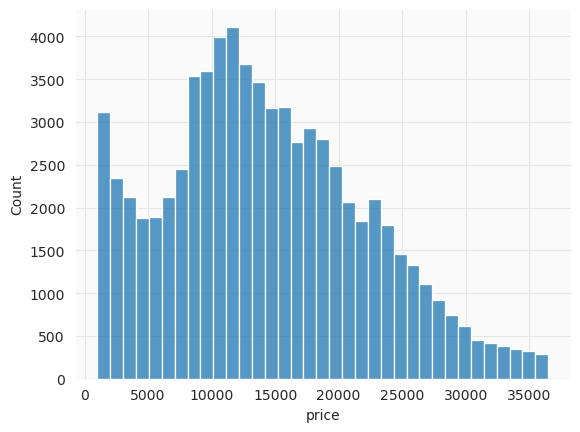

In [309]:
sns.histplot(data=data, x='price', bins=35);

In [310]:
data['price'].describe()

count    71884.000000
mean     14321.449377
std       7827.057238
min       1000.000000
25%       8800.000000
50%      13500.000000
75%      19500.000000
max      36500.000000
Name: price, dtype: float64

Из характеристик и построенной гистограммы видно, что:
- стоимость большинства автомобилей марки Ford находится в диапазоне 1000 до 22000;
- на гистограмме присутствует 2 пика, которые свидетельствуют о том, что чаще всего встречаются автомобили стоимостью 2000 и 9000 - 16000. 
- авто стоимостью более 30000 встречается редко;
- минимальная стоимость составляет 1000;
- максимальная стоимость составляет 36500.

Рассмотрим составляющие VIN кода:

In [311]:
name_columns = [('wmi', 'мировой идентификатор производителя'),
                ('restraint', 'система безопасности'),
                ('line', 'линия'),
                ('series', 'серия'),
                ('body', 'вид кузова'),
                ('engine', 'двигатель'),
                ('year', 'год выпуска модели'),
                ('plant', 'сборочный цех')
]

wmi - мировой идентификатор производителя
Уникальные значения признака wmi: ['2FM' '3FA' '1FM' '1FA' '1FT' '1ZV' '1FD' '2FA' '2FT' '1FB' '4F2' '4F4'
 '3FT' '4N2']


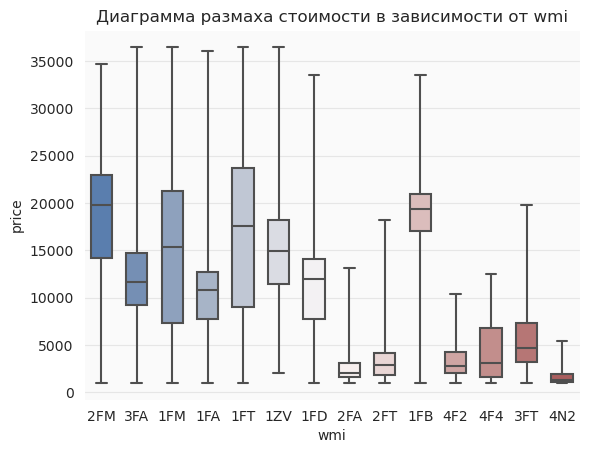

restraint - система безопасности
Уникальные значения признака restraint: ['D' '6' 'H' 'C' '5' 'F' 'Z' 'G' 'B' 'N' 'J' 'P' 'M' 'R' 'E' 'S' 'K' 'Y'
 'X' '8' 'W' '7' 'V' 'L' '4' 'A']


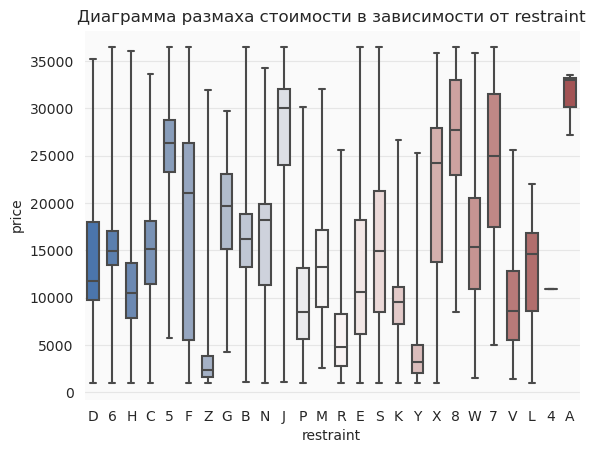

line - линия
Уникальные значения признака line: ['K' 'P' 'U' 'W' 'X' 'E' 'T' 'F' 'R' 'S' 'Z' 'A' 'N' 'Y']


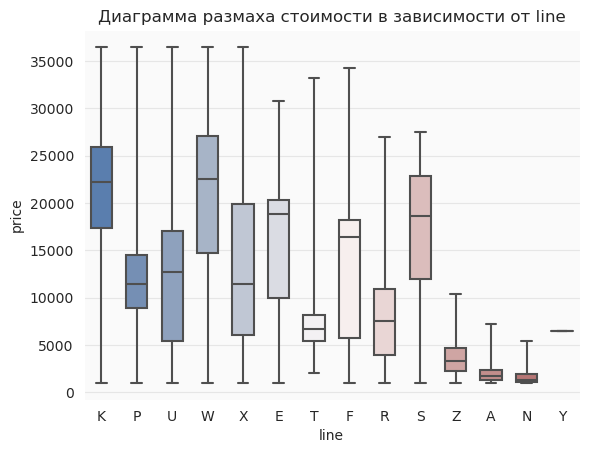

series - серия
Уникальные значения признака series: ['3' '0' '2' '8' '1' '6' '9' '5' '4' '7']


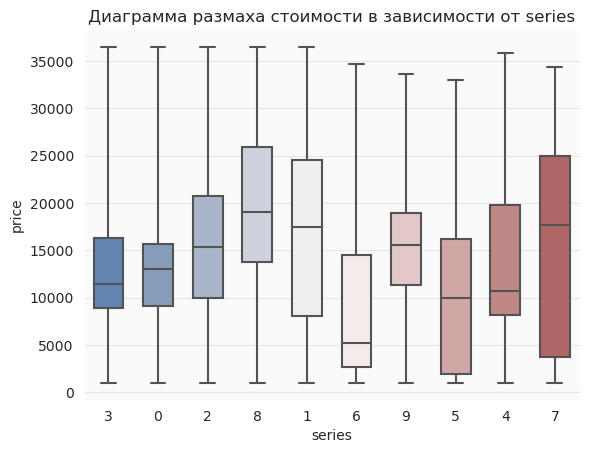

body - вид кузова
Уникальные значения признака body: ['J' 'H' '8' 'G' 'E' 'D' 'C' '4' 'K' 'B' '6' '2' 'F' 'R' '1' '0' '5' '7'
 'L' 'A' '3' 'M' '9' 'N' 'T' 'P' 'S' 'Z' 'Y' 'X' 'U']


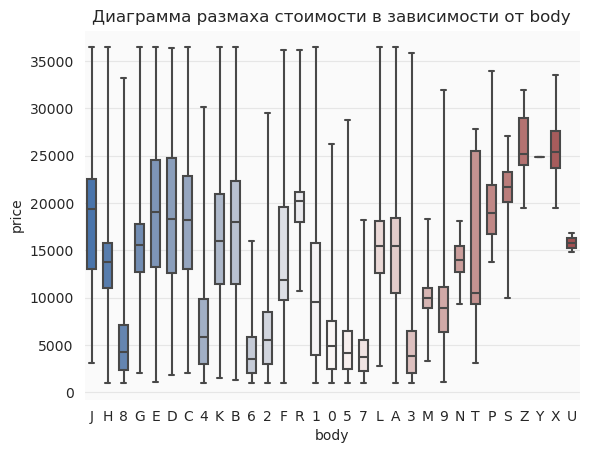

engine - двигатель
Уникальные значения признака engine: ['C' '7' 'Z' 'X' '8' 'F' 'T' 'W' 'G' 'M' '5' '1' '9' 'H' 'A' '2' 'N' 'U'
 'E' 'R' 'L' 'P' 'D' 'J' 'K' '3' '4' 'V' '6' 'S' 'Y' 'B']


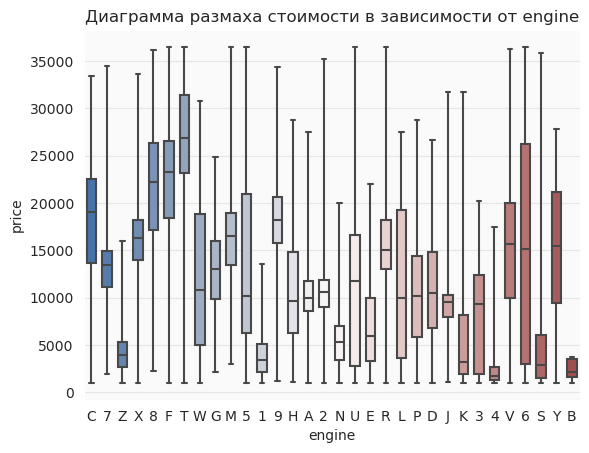

year - год выпуска модели
Уникальные значения признака year: ['B' 'E' '7' 'D' 'C' '3' 'A' '5' '4' '9' '8' 'X' '6' 'Y' 'F' '2' 'W' 'V'
 '1' 'S' 'T' 'R' 'H' 'K' 'P']


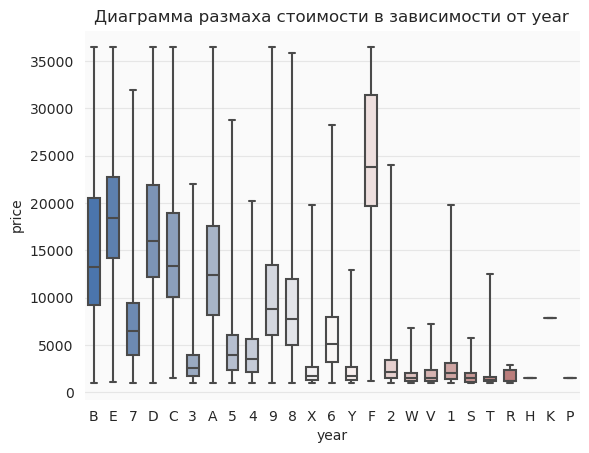

plant - сборочный цех
Уникальные значения признака plant: ['B' 'R' 'U' 'G' 'F' 'K' '5' 'D' 'E' 'N' 'L' 'W' 'P' 'M' 'A' 'X' 'C' 'Z'
 'H' 'Y' 'T']


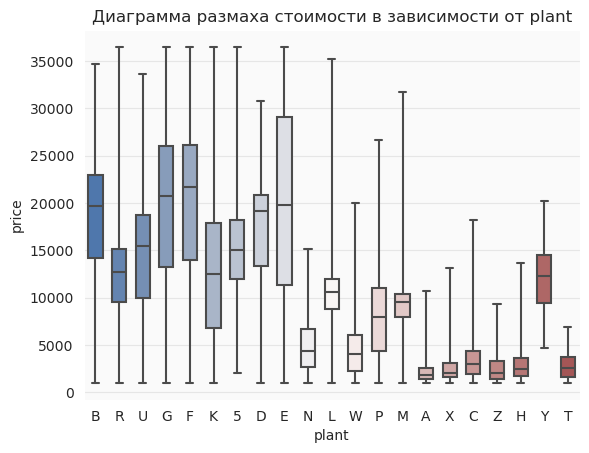

In [312]:
for col in name_columns:
    print(BOLD + f'{col[0]} - {col[1]}' + END)
    print(f'Уникальные значения признака {col[0]}: {data[col[0]].unique()}')
    sns.boxplot(data, x=col[0], y='price',
    whis=[0, 100], width=.6, palette='vlag')
    plt.title(f'Диаграмма размаха стоимости в зависимости от {col[0]}')
    plt.show()

Из графиков boxplot видно:
- по wmi:
    - у авто производителей 2FA, 2FT, 4F2, 4F4 медиана равна 2000 - 2500,
    - самая низкая медиана у производителя 4N2 около 1000, также у этого производителя самая низкая дисперсия стоимости;
    - наибольшая медиана у производителей 2FM и 1FB, но при этом у 1FB меньше межквартильный размах;
- по restraint:
    - у авто с системой безопастности Z и Y  - самая низкая медиана около 2000-2500;
    - у авто с системой безопастности A медиана составляет 33000, также стоимость данных автомобилей имеет маленькую дисперсию;
    - мало наблюдений среди авто с системой безопастности 4;
- по line:
    - низкая медиана 1000-3000 и дисперсия среди авто с line Z, A, N;
    - медиана среди авто с line T, R составляет 6000-7000;
    - мало наблюдений среди авто с line Y;
- по series:
    - наименьшая медиана у авто серии 6, она составляет около 5000;
    - наибольший межквартильный размах у авто серии 7;
- по body:
    - наименьшая медиана у авто с типов кузова 4, 6, 2, 0, 5, 7, 3 около 3500-5500;
    - наибольшая медиана у авто с типом кузова Z, X около 25000;
    - мало наблюдений среди авто с line типом кузова Y;
- по engine:
    - наименьшая медиана у авто с двигателем Z, 1, 4, B около 2000-4000;
    - наименьшая дсиперсия у авто с двигателем B;
- по year:
    - наименьшая медиана у авто с годом 3, 5, 4, X, Y, 2, W, V, 1, S, T, R около 1000-4000;
    - мало наблюдений среди авто с годом H, K, P;
    - наибольшая медиана у авто с годом F;
- по plant:
    - наименьшая медиана у авто с plant N, W, A, X, C, Z, H, T около 2000-4000.

### `Подготовка признаков для построения моделей`

Удалим малоинформативные признаки check и vis (контрольная цифра и номер авто), выделем целевой признак и разделим датасет на тренировочный и тестовый:

In [313]:
X = data.drop(['check', 'vis', 'price'], axis=1)
y = data['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=RANDOM_STATE)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((57507, 8), (14377, 8), (57507,), (14377,))

Категориальные признаки:

In [316]:
cat_features = X_train.select_dtypes(include='object').columns.tolist()
cat_features

['wmi', 'restraint', 'line', 'series', 'body', 'engine', 'year', 'plant']

Подготовим пайплайн для обработки категориальных признаков для модели LightGBM

In [317]:
col_trans = make_column_transformer((OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False),
                                     cat_features),
                                    remainder='passthrough',
                                    n_jobs=-1)
col_trans

ColumnTransformer(n_jobs=-1, remainder='passthrough',
                  transformers=[('onehotencoder',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='ignore',
                                               sparse_output=False),
                                 ['wmi', 'restraint', 'line', 'series', 'body',
                                  'engine', 'year', 'plant'])])

### `Построение модели`

Исследуем 2 модели: LightGBM и Catboost

- LightGBM

In [320]:
def objective(trial):
    param = {
        "n_estimators": trial.suggest_int("n_estimators", 330, 500),
        "max_depth": trial.suggest_int("max_depth", 2, 8),
         "num_leaves": trial.suggest_int("num_leaves", 2, 12),
        "lambda_l1": trial.suggest_float("lambda_l1", 0.3, 0.8),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "boostings": trial.suggest_categorical("boostings", ["gbdt", "dart", "goss"]),
        
    }
    model_lgbm = LGBMRegressor(**param, 
                               random_state=RANDOM_STATE,
                               objective = 'regression',
                               metric ='rmse',
                               verbose=-1)
    lgbm_pipeline = make_pipeline(col_trans, model_lgbm)
    score_lgbm = - cross_val_score(lgbm_pipeline, 
                                   X_train, y_train, 
                                   cv=5, 
                                   scoring='neg_root_mean_squared_error'
                                  ).mean()
    return score_lgbm
sampler = optuna.samplers.RandomSampler(seed=RANDOM_STATE)
study_lgbm = optuna.create_study(sampler=sampler, direction='minimize')
study_lgbm.optimize(objective, n_trials=7)
print('Лучшие гиперпараметры LightGBM:', study_lgbm.best_params)
print('RMSE LightGBM на тренировочной выборке:', study_lgbm.best_value)

[I 2024-04-23 10:19:35,839] A new study created in memory with name: no-name-444a2d9e-906d-4fd4-8a60-f517f37f2be9
/home/evgenya/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/evgenya/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [1, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/evgenya/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
[I 2024-04-23 10:19:40,034] Trial 0 finished with value: 2968.07854564721 and parameters: {'n_estimators': 477, 'max_depth': 5, 'num_leaves': 3, 'lambda_l1': 0.3062010700774558, 'learn

Лучшие гиперпараметры LightGBM: {'n_estimators': 472, 'max_depth': 8, 'num_leaves': 8, 'lambda_l1': 0.536810200532422, 'learning_rate': 0.26646742008307817, 'boostings': 'goss'}
RMSE LightGBM на тренировочной выборке: 2786.674472393685


In [321]:
def objective(trial):
    param = {
        "iterations": trial.suggest_int("iterations", 780, 800),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"])
    }
    train_pool = Pool(X_train,
                  label=y_train,
                  cat_features=cat_features
                      )
    test_pool = Pool(X_test,
                  label=y_test,
                  cat_features=cat_features
                  )
    model_cbc = CatBoostRegressor(**param, 
                                   eval_metric='RMSE',
                                   thread_count=-1, 
                                   random_seed=RANDOM_STATE, 
                                   verbose=0, 
                                   cat_features=cat_features)
    score_cbc = - cross_val_score(model_cbc, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error').mean()
    return score_cbc
sampler = optuna.samplers.RandomSampler(seed=RANDOM_STATE)
study_cbc = optuna.create_study(sampler=sampler, direction='minimize')
study_cbc.optimize(objective, n_trials=7)
print('Лучшие гиперпараметры Catboost:', study_cbc.best_params)
print('RMSE Catboost на тренировочной выборке:', study_cbc.best_value)

[I 2024-04-23 10:20:43,077] A new study created in memory with name: no-name-7c601fbc-6e80-4e76-aec6-b15ea9d463d9
[I 2024-04-23 10:21:48,255] Trial 0 finished with value: 2773.474872965705 and parameters: {'iterations': 798, 'bootstrap_type': 'Bayesian'}. Best is trial 0 with value: 2773.474872965705.
[I 2024-04-23 10:22:53,139] Trial 1 finished with value: 2768.6472635943323 and parameters: {'iterations': 800, 'bootstrap_type': 'MVS'}. Best is trial 1 with value: 2768.6472635943323.
[I 2024-04-23 10:23:56,850] Trial 2 finished with value: 2772.8780693033063 and parameters: {'iterations': 784, 'bootstrap_type': 'Bayesian'}. Best is trial 1 with value: 2768.6472635943323.
[I 2024-04-23 10:25:01,062] Trial 3 finished with value: 2767.491270340136 and parameters: {'iterations': 795, 'bootstrap_type': 'MVS'}. Best is trial 3 with value: 2767.491270340136.
[I 2024-04-23 10:26:08,254] Trial 4 finished with value: 2774.6186495498414 and parameters: {'iterations': 799, 'bootstrap_type': 'Bayes

Лучшие гиперпараметры Catboost: {'iterations': 795, 'bootstrap_type': 'MVS'}
RMSE Catboost на тренировочной выборке: 2767.491270340136


Вывод: На тренировочном датасете 
- у модели LightGBM <b>RMSE</b> составляет <b>2787</b> с наилучшими параметрами:
    - 'n_estimators': 472, 
    - 'max_depth': 8, 
    - 'num_leaves': 8, 
    - 'lambda_l1': 0.536810200532422, 
    - 'learning_rate': 0.26646742008307817, 
    - 'boostings': 'goss'
- у модели Catboost <b>RMSE</b> составляет <b>2767</b> с наилучшими параметрами:
    - 'iterations': 795, 
    - 'bootstrap_type': 'MVS'

### `Тестирование модели`

Наилучшее качество на тренировочной выборке показала модель Catboost. Обучим её с наилучшими параметрами и протестируем:

In [322]:
model_cbc = CatBoostRegressor(**study_cbc.best_params, 
                              random_state=RANDOM_STATE, 
                              verbose=False,
                              cat_features=cat_features)
model_cbc.fit(X_train, y_train)
preds_test = model_cbc.predict(X_test)
rmse_test = mean_squared_error(y_test, preds_test, squared=False)
print(f'RMSE на тестовой выборке: {rmse_test}')

RMSE на тестовой выборке: 2738.243656157085


#### `Константная модель`

In [323]:
dummy = DummyRegressor(strategy='mean')
dummy.fit(X_train, y_train)
dummy_preds = dummy.predict(X_test)
dummy_rmse = mean_squared_error(y_test, dummy_preds, squared=False)
print('RMSE константной модели:', dummy_rmse)

RMSE константной модели: 7815.019165320646


#### `Оценка важности признаков`

In [324]:
features_value = pd.DataFrame({
    'value':model_cbc.feature_importances_,
    'feature':X_train.columns.tolist()}).sort_values(by='value',ascending=False)

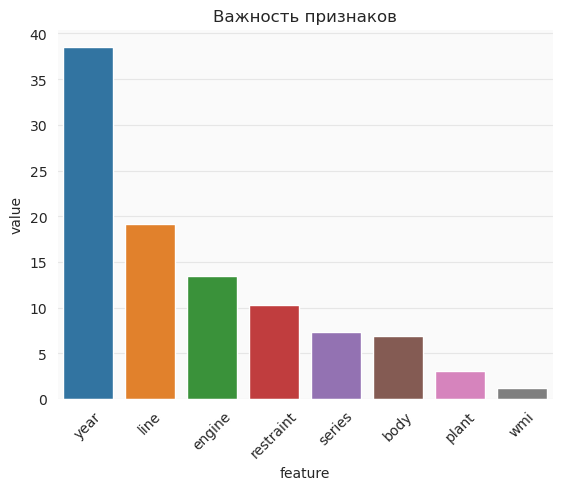

In [325]:
sns.barplot (x='feature', y='value', data=features_value)
plt.title('Важность признаков')
plt.xticks(rotation=45)
plt.show()

Вывод:
- качество Catboost на тестовых данных с наилучшими параметрами составляет <b>RMSE = 2738</b>;
- выбранная модель имеет качество (RMSE) лучше, чем у модели DummyRegressor, что свидетельствует о ее адекватности;
- по важности признаков:
    - наиболее важным признаком являются year;
    - средними по важности являются line, engine, restraint, body, series;
    - наименее важными являются plant, wmi.

### `Функция, предсказывающая стоимость авто`

In [259]:
def car_price_details(model, vin_str):
    vin = decode_vin(vin_str, False)
    if len(check_valid(vin_str, False)) != 0:
        print('Номер невалиден')
        return
    if vin['wmi'][0] not in FORD_WMI.keys():
        print('Автомобиль не марки Ford, невозможно предсказать цену')
        return
    print(FORD_WMI[vin['wmi'][0]])
    vin = vin.drop(['check', 'vis'], axis=1)
    price_predicted = model.predict(vin)
    print(f'Приблизительная стоимость автомобиля составляет {price_predicted[0]}')

In [260]:
car_price_details(model_cbc, '1FT7X2B6XCEB34867')

Ford truck
Приблизительная стоимость автомобиля составляет 18050.006095337634


In [261]:
car_price_details(model_cbc, '1TT7X2B6XCEB34867')

Автомобиль не марки Ford, невозможно предсказать цену


In [262]:
car_price_details(model_cbc, '11111')

Номер невалиден


<b>ИТОГОВЫЕ ВЫВОДЫ:</b>

<b>В результате предобработки данных:</b>
- изменен тип столбца price на float;
- удалены явные дубликаты.

<b>В результате исследования определено:</b>

из характеристик и построенной гистограммы целевого признака:
- стоимость большинства автомобилей марки Ford находится в диапазоне 1000 до 22000;
- на гистограмме присутствует 2 пика, которые свидетельствуют о том, что чаще всего встречаются автомобили стоимостью 2000 и 9000 - 16000. 
- авто стоимостью более 30000 встречается редко;
- минимальная стоимость составляет 1000;
- максимальная стоимость составляет 36500.

из графиков boxplot составляющих VIN-кода видно:
- по wmi:
    - у авто производителей 2FA, 2FT, 4F2, 4F4 медиана равна 2000 - 2500,
    - самая низкая медиана у производителя 4N2 около 1000, также у этого производителя самая низкая дисперсия стоимости;
    - наибольшая медиана у производителей 2FM и 1FB, но при этом у 1FB меньше межквартильный размах;
- по restraint:
    - у авто с системой безопастности Z и Y - самая низкая медиана около 2000-2500;
    - у авто с системой безопастности A медиана составляет 33000, также стоимость данных автомобилей имеет маленькую дисперсию;
    - мало наблюдений среди авто с системой безопастности 4;
- по line:
    - низкая медиана 1000-3000 и дисперсия среди авто с line Z, A, N;
    - медиана среди авто с line T, R составляет 6000-7000;
    - мало наблюдений среди авто с line Y;
- по series:
    - наименьшая медиана у авто серии 6, она составляет около 5000;
    - наибольший межквартильный размах у авто серии 7;
- по body:
    - наименьшая медиана у авто с типов кузова 4, 6, 2, 0, 5, 7, 3 около 3500-5500;
    - наибольшая медиана у авто с типом кузова Z, X около 25000;
    - мало наблюдений среди авто с line типом кузова Y;
- по engine:
    - наименьшая медиана у авто с двигателем Z, 1, 4, B около 2000-4000;
    - наименьшая дсиперсия у авто с двигателем B;
- по year:
    - наименьшая медиана у авто с годом 3, 5, 4, X, Y, 2, W, V, 1, S, T, R около 1000-4000;
    - мало наблюдений среди авто с годом H, K, P;
    - наибольшая медиана у авто с годом F;
- по plant:
    - наименьшая медиана у авто с plant N, W, A, X, C, Z, H, T около 2000-4000.
    
<b>В результате построения моделей определено:</b>
- у модели LightGBM <b>RMSE</b> составляет <b>2787</b> с наилучшими параметрами:
    - 'n_estimators': 472, 
    - 'max_depth': 8, 
    - 'num_leaves': 8, 
    - 'lambda_l1': 0.536810200532422, 
    - 'learning_rate': 0.26646742008307817, 
    - 'boostings': 'goss'
- у модели Catboost <b>RMSE</b> составляет <b>2767</b> с наилучшими параметрами:
    - 'iterations': 795, 
    - 'bootstrap_type': 'MVS'
    
<b>В результате тестирования моделей определено:</b>
- качество модели Catboost на тестовых данных с наилучшими параметрами составляет <b>RMSE = 2738</b>;
- выбранная модель имеет качество (RMSE) лучше, чем у модели DummyRegressor, что свидетельствует о ее адекватности;
- по важности признаков:
    - наиболее важным признаком являются year;
    - средними по важности являются line, engine, restraint, body, series;
    - наименее важными являются plant, wmi.
    
Была написана функцию, которая на вход принимает VIN-код (строку), проверяет код на валидность, если указан VIN-код автомобиля марки Ford, то выдает информацию об автомобиле и предсказывает стоимость, если VIN-код автомобиля другой марки, то выводит сообщение 'Автомобиль не марки Ford, невозможно предсказать цену'.